In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def regression_metrics(y_true, y_pred, n_features):
    """

    Parameters:
    - y_true: 실제 값 (array-like)
    - y_pred: 예측 값 (array-like)
    - n_features: 입력 변수(특성) 수 (int)

    Returns:
    - dict: MSE, MAE, RMSE, R2, Adjusted R2
    """
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - n_features - 1)

    return {
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2, # 1-어쩌구저쩌구(성능을저하시키는지표) = 전체 성능에서 얼마나 방해가 있었는지 알려주는 지표. 얘가 마이너스면? 모델이 동전던지기보다 못 맞힌다.
        "Adjusted R2": adj_r2
    }

# 회귀 모델 만들기

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/꾸러기_수비대/preprocessed/sellers_bf.csv')
test = pd.read_csv('/content/drive/MyDrive/꾸러기_수비대/preprocessed/sellers_2018.csv')

In [ ]:
train['avg_order_sale'] = train['total_sale']/(train['order_cnt'])
test['avg_order_sale'] = test['total_sale']/(test['order_cnt'])

In [ ]:
train = train[['monthly_avg_orders', 'review_score', 'delay_rate', 'order_cnt', 'total_sale', 'product_cnt', 'avg_order_sale']]
test = test[['monthly_avg_orders', 'review_score', 'delay_rate', 'order_cnt', 'total_sale', 'product_cnt', 'avg_order_sale']]

In [ ]:
# train.fillna(train['review_score'].median(), inplace=True)
# test.fillna(test['review_score'].median(), inplace=True)

In [ ]:
train

,monthly_avg_orders,review_score,delay_rate,order_cnt,total_sale,product_cnt,avg_order_sale
0,1.500000,3.666667,0.00,3,2685.00,1,895.000000
1,18.818182,3.994975,2.90,207,21275.23,9,102.778889
2,10.500000,4.200000,11.90,42,781.80,15,18.614286
3,11.083333,4.225352,0.00,133,15159.93,70,113.984436
4,1.000000,5.000000,0.00,1,98.00,1,98.000000
...,...,...,...,...,...,...,...
1667,1.000000,3.000000,0.00,1,14.90,1,14.900000
1668,1.000000,4.111111,11.11,9,1254.10,7,139.344444
1669,2.000000,4.142857,37.50,8,1099.92,2,137.490000
1670,3.333333,3.470588,5.00,20,3374.30,15,168.715000


In [ ]:
X_temp = train.fillna(0)

<Axes: >

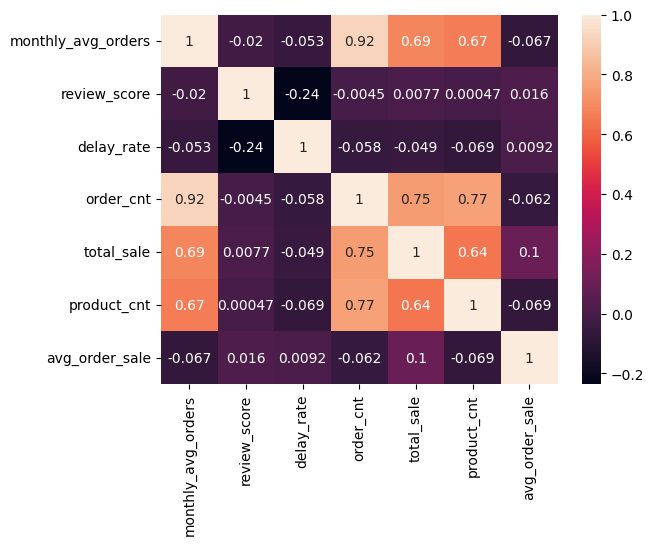

In [ ]:
sns.heatmap(X_temp.corr(), annot=True) # order_cnt 주의

<Axes: >

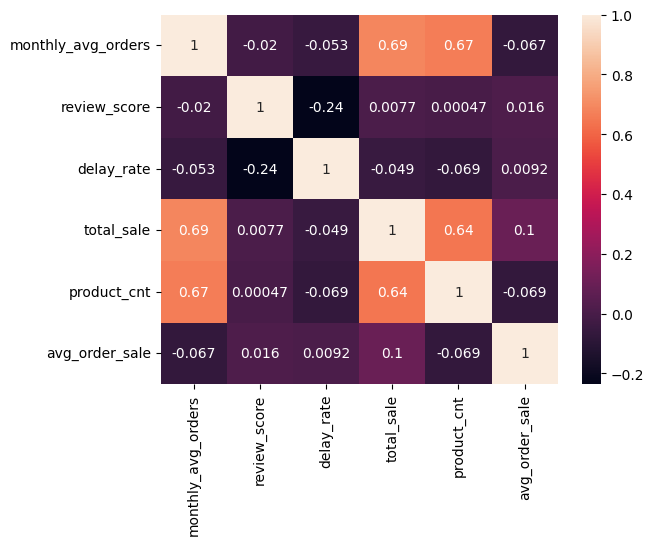

In [ ]:
X_temp2 = X_temp[['monthly_avg_orders', 'review_score', 'delay_rate', 'total_sale', 'product_cnt', 'avg_order_sale']]
sns.heatmap(X_temp2.corr(), annot=True)

상관계수와 다중공선성 확인

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_temp.values, i) for i in range(X_temp.shape[1])]
vif["features"] = X_temp.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif

,VIF Factor,features
0,1.228720,delay_rate
1,1.321053,avg_order_sale
2,1.951851,review_score
3,2.756209,total_sale
4,3.182876,product_cnt
5,8.797118,monthly_avg_orders
6,11.745501,order_cnt


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_temp2.values, i) for i in range(X_temp2.shape[1])]
vif["features"] = X_temp2.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif # 모든 regression에서 order_cnt 사용 금지

,VIF Factor,features
0,1.227748,delay_rate
1,1.317278,avg_order_sale
2,1.808583,review_score
3,2.534581,product_cnt
4,2.535994,total_sale
5,2.867964,monthly_avg_orders


일부 변수의 로그 변환(치우침이 심함): monthly_avg_orders, total_sale, product_cnt, avg_order_sale

In [ ]:
# monthly_avg_orders, total_sale, product_cnt, avg_order_sale 로그 변환
train['monthly_avg_orders_log'] = np.log1p(train['monthly_avg_orders'])
train['total_sale_log'] = np.log1p(train['total_sale'])
train['product_cnt_log'] = np.log1p(train['product_cnt'])
train['avg_order_sale_log'] = np.log1p(train['avg_order_sale'])
test['monthly_avg_orders_log'] = np.log1p(test['monthly_avg_orders'])
test['total_sale_log'] = np.log1p(test['total_sale'])
test['product_cnt_log'] = np.log1p(test['product_cnt'])
test['avg_order_sale_log'] = np.log1p(test['avg_order_sale'])

## 회귀 1번: target - total_sale

X, y set 선정

In [ ]:
# 1. 타겟을 무엇으로 잡는가? 수익률로? <- 수익률이라면 어떻게 계산해야 할지 전체수익/order_cnt <- monthly avg order? <-> monthly avg sale?
# 2. monthly avg order <-> order cnt 사실상 관계가 아주 있는 feature라서 넣으면 안 됨
# 3. target 후보: 'total_sale' & 'total_sale/np.sqrt(order_cnt)=avg_order_sale' & review_score

features = ['review_score', 'delay_rate', 'product_cnt_log']  # 사용하고자 하는 feature명
target = 'total_sale_log' # 예측 대상 컬럼명
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

모델 작성

In [ ]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    tree_method="hist",
    device="cuda",
    random_state=42)

param_grid = {
    'n_estimators': [200, 300, 500, 700],
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]}

In [ ]:
grid_search1 = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

In [ ]:
grid_search1.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device='cuda',
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=No...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [2, 3, 4, 5],
                         'n_estimators': [200, 300, 500, 700]},
             scoring='neg_mean_absolute_error', verbose=1)

In [ ]:
print("Best Parameters:", grid_search1.best_params_)
print("Best Score (Negative MAE):", grid_search1.best_score_)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Best Score (Negative MAE): -0.8180228636367612


In [ ]:
best_model_total_sale = grid_search1.best_estimator_

In [ ]:
y_pred_total_sale_log = best_model_total_sale.predict(X_test)
y_pred_total_sale = np.expm1(y_pred_total_sale_log)

In [ ]:
regression_metrics(np.expm1(y_test), y_pred_total_sale, 3)

{'MSE': 71774107.01396875,
 'MAE': 2350.8452869846033,
 'RMSE': np.float64(8471.960045583828),
 'R2': 0.3438754755836766,
 'Adjusted R2': 0.342695395503791}

모델 학습 완료: feature importances 확인

In [ ]:
best_model_total_sale.feature_importances_

array([0.05153278, 0.06618062, 0.8822866 ], dtype=float32)

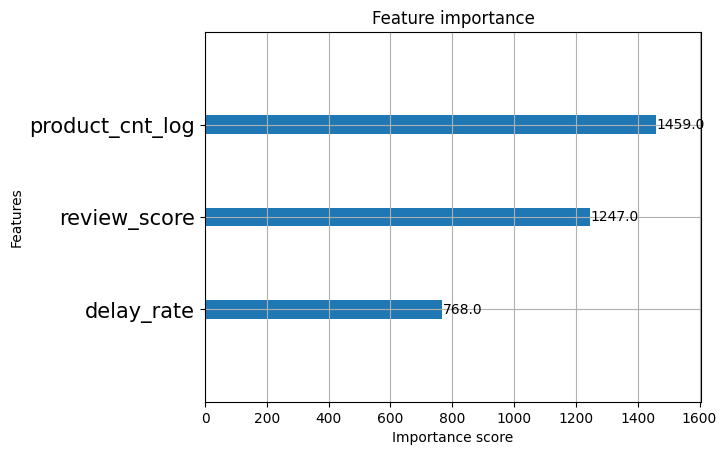

In [ ]:
from xgboost import plot_importance
plot_importance(best_model_total_sale)
plt.yticks(fontsize=15)
plt.show()

lightgbm 모델

In [ ]:
# 1. 타겟을 무엇으로 잡는가? 수익률로? <- 수익률이라면 어떻게 계산해야 할지 전체수익/order_cnt <- monthly avg order? <-> monthly avg sale?
# 2. monthly avg order <-> order cnt 사실상 관계가 아주 있는 feature라서 넣으면 안 됨
# 3. target 후보: 'total_sale' & 'total_sale/np.sqrt(order_cnt)=avg_order_sale' & review_score

features = ['review_score', 'delay_rate', 'product_cnt_log']  # 사용하고자 하는 feature명
target = 'total_sale' # 예측 대상 컬럼명
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [ ]:
from lightgbm import LGBMRegressor

# 90% 분위수 (상위 10%)
model_90 = LGBMRegressor(
    objective='quantile',
    alpha=0.9,
    random_state=42
)

param_grid = {
    'n_estimators': [200, 500],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'num_leaves': [15, 31]
}

grid_search4 = GridSearchCV(
    estimator=model_90,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # 분위수 회귀엔 MAE가 적합
    cv=3,
    verbose=1,
    n_jobs=-1
)


In [ ]:
grid_search4.fit(X_train, y_train)
print("Best Params:", grid_search4.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 549
[LightGBM] [Info] Number of data points in the train set: 2308, number of used features: 3
[LightGBM] [Info] Start training from score 6775.949219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [ ]:
print("Best score(Negative MAE):", grid_search4.best_score_)

Best score(Negative MAE): -4518.342112365403


In [ ]:
best_model4 = grid_search4.best_estimator_

In [ ]:
y_pred_total_sale = best_model4.predict(X_test)

In [ ]:
y_pred_total_sale = np.expm1(y_pred_total_sale)

/tmp/ipython-input-1358218786.py:1: RuntimeWarning: overflow encountered in expm1
  y_pred_total_sale = np.expm1(y_pred_total_sale)


In [ ]:
regression_metrics(y_test, y_pred_total_sale, 3) #성능 안 나옴

{'MSE': 153158824.6675687,
 'MAE': 5020.576504407308,
 'RMSE': np.float64(12375.735318257606),
 'R2': -0.4001046502133965,
 'Adjusted R2': -0.4026228240447154}

RF 모델 실험

In [ ]:
train['review_score_x_product_cnt'] = train['review_score'] * train['product_cnt']
test['review_score_x_product_cnt'] = test['review_score'] * test['product_cnt']

In [ ]:
# 1. 타겟을 무엇으로 잡는가? 수익률로? <- 수익률이라면 어떻게 계산해야 할지 전체수익/order_cnt <- monthly avg order? <-> monthly avg sale?
# 2. monthly avg order <-> order cnt 사실상 관계가 아주 있는 feature라서 넣으면 안 됨
# 3. target 후보: 'total_sale' & 'total_sale/np.sqrt(order_cnt)=avg_order_sale' & review_score

# rf모델로 확정 후 feature custom

features = ['review_score', 'delay_rate', 'product_cnt_log', 'review_score_x_product_cnt']  # 사용하고자 하는 feature명
target = 'total_sale' # 예측 대상 컬럼명
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [ ]:
# from sklearn.preprocessing import PolynomialFeatures

# features = ['review_score', 'delay_rate', 'product_cnt_log']
# target = 'total_sale'
# X_train = train[features]
# X_test = test[features]
# y_train = train[target]
# y_test = test[target]

# # 상호작용 항만 생성
# # poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
# # 2차항 포함
# poly = PolynomialFeatures(degree=2, interaction_only=False)
# X_train_poly = poly.fit_transform(X_train)
# X_test_poly = poly.transform(X_test)

# # 새로운 feature 이름 가져오기
# feature_names = poly.get_feature_names_out(features)

# # DataFrame으로 변환
# X_train_poly_df = pd.DataFrame(X_train_poly, columns=feature_names, index=X_train.index)
# X_test_poly_df = pd.DataFrame(X_test_poly, columns=feature_names, index=X_test.index)


In [ ]:
# X_train_poly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2308 entries, 0 to 2307
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   1                             2308 non-null   float64
 1   review_score                  2308 non-null   float64
 2   delay_rate                    2308 non-null   float64
 3   product_cnt_log               2308 non-null   float64
 4   review_score^2                2308 non-null   float64
 5   review_score delay_rate       2308 non-null   float64
 6   review_score product_cnt_log  2308 non-null   float64
 7   delay_rate^2                  2308 non-null   float64
 8   delay_rate product_cnt_log    2308 non-null   float64
 9   product_cnt_log^2             2308 non-null   float64
dtypes: float64(10)
memory usage: 180.4 KB


In [ ]:
# # column drop
# X_train_poly_df.drop('1', axis=1, inplace=True)
# X_test_poly_df.drop('1', axis=1, inplace=True)

In [ ]:
# X_train_poly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2308 entries, 0 to 2307
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   review_score                  2308 non-null   float64
 1   delay_rate                    2308 non-null   float64
 2   product_cnt_log               2308 non-null   float64
 3   review_score^2                2308 non-null   float64
 4   review_score delay_rate       2308 non-null   float64
 5   review_score product_cnt_log  2308 non-null   float64
 6   delay_rate^2                  2308 non-null   float64
 7   delay_rate product_cnt_log    2308 non-null   float64
 8   product_cnt_log^2             2308 non-null   float64
dtypes: float64(9)
memory usage: 162.4 KB


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 0.7, None]
}

grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search_rf.fit(X_train, y_train)
print("Best Params:", grid_search_rf.best_params_)
print("Best score(Negative RMSE):", grid_search_rf.best_score_)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best Params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best score(Negative RMSE): 0.48574845666995375


In [ ]:
# 예측 및 평가
y_pred_rf = grid_search_rf.predict(X_test)
regression_metrics(y_test, y_pred_rf, n_features=X_test.shape[1])

{'MSE': 66290044.75815683,
 'MAE': 2718.4342059677356,
 'RMSE': np.float64(8141.869856375551),
 'R2': 0.39400814722755795,
 'Adjusted R2': 0.3925540575988299}

In [ ]:
# 예측 및 평가
y_pred_rf = grid_search_rf.predict(X_test)
regression_metrics(y_test, y_pred_rf, n_features=X_test.shape[1])

{'MSE': 44451785.8920943,
 'MAE': 2384.268816491258,
 'RMSE': np.float64(6667.217252504548),
 'R2': 0.38326522512749595,
 'Adjusted R2': 0.3821940401081776}

In [ ]:
y_pred_rf = grid_search_rf.predict(X_test)
y_pred_rf = np.expm1(y_pred_rf)
regression_metrics(np.expm1(y_test), y_pred_rf, n_features=X_test.shape[1])

/tmp/ipython-input-2777981153.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')


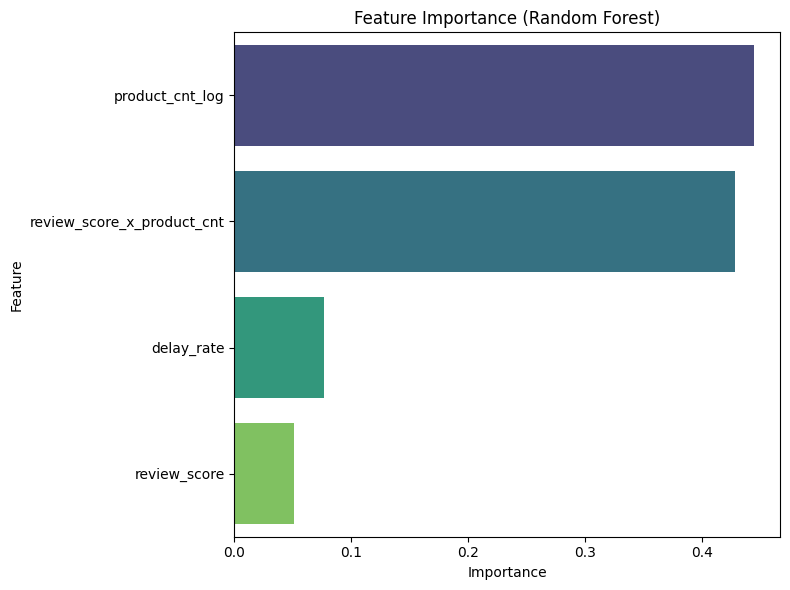

In [ ]:
# 모델과 feature 이름을 준비
model = grid_search_rf.best_estimator_
importances = model.feature_importances_
feature_names = X_train.columns  # X_train이 DataFrame이면 .columns 가능

# 데이터프레임으로 정리
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()


In [ ]:
best_rf_final = grid_search_rf.best_estimator_

In [ ]:
import joblib

# 저장
joblib.dump(best_rf_final, '/content/drive/MyDrive/꾸러기_수비대/best_rf_model.pkl')

# # 불러오기
# loaded_rf = joblib.load('best_rf_model.pkl')
# y_pred_loaded = loaded_rf.predict(X_test)


['/content/drive/MyDrive/꾸러기_수비대/best_rf_model.pkl']

X, y set 선정

In [ ]:
# 1. 타겟을 무엇으로 잡는가? 수익률로? <- 수익률이라면 어떻게 계산해야 할지 전체수익/order_cnt <- monthly avg order? <-> monthly avg sale?
# 2. monthly avg order <-> order cnt 사실상 관계가 아주 있는 feature라서 넣으면 안 됨
# 3. target 후보: 'total_sale' & 'total_sale/np.sqrt(order_cnt)=avg_order_sale' & review_score

features = ['monthly_avg_orders', 'review_score', 'delay_rate', 'product_cnt']  # 사용하고자 하는 feature명
target = 'avg_order_sale' # 예측 대상 컬럼명
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [ ]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    tree_method="hist",
    device="cuda",
    random_state=42)

param_grid = {
    'n_estimators': [200, 300, 500, 700],
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]}

In [ ]:
grid_search2 = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

In [ ]:
grid_search2.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device='cuda',
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=No...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [2, 3, 4, 5],
                         'n_estimators': [200, 300, 500, 700]},
             scoring='neg_mean_absolute_error', verbose=1)

In [ ]:
print("Best Parameters:", grid_search2.best_params_)
print("Best Score (Negative MAE):", grid_search2.best_score_)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 200}
Best Score (Negative MAE): -136.69694284100004


In [ ]:
best_model_avg_order_sale = grid_search2.best_estimator_

In [ ]:
# y_pred_avg_order_sale_log = best_model_avg_order_sale.predict(X_test)
# y_pred_avg_order_sale = np.expm1(y_pred_avg_order_sale_log)

y_pred_avg_order_sale = best_model_avg_order_sale.predict(X_test)

In [ ]:
regression_metrics(y_test, y_pred_avg_order_sale, 4)

{'MSE': 131912.24375451566,
 'MAE': 154.36931999732184,
 'RMSE': np.float64(363.1972518542998),
 'R2': 0.010332366010050942,
 'Adjusted R2': 0.00795763863395027}

feature importance

In [ ]:
best_model_avg_order_sale.feature_importances_

array([0.39824325, 0.27778244, 0.07719942, 0.24677493], dtype=float32)

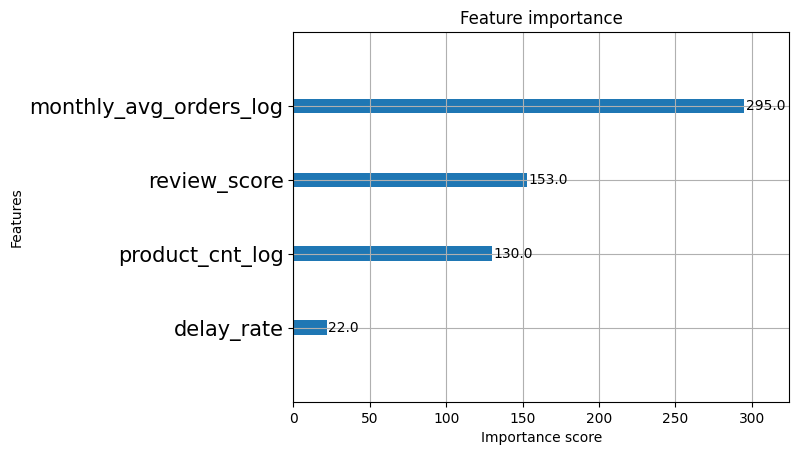

In [ ]:
from xgboost import plot_importance
plot_importance(best_model_avg_order_sale)
plt.yticks(fontsize=15)
plt.show()

X, y set 선정

In [ ]:
# 1. 타겟을 무엇으로 잡는가? 수익률로? <- 수익률이라면 어떻게 계산해야 할지 전체수익/order_cnt <- monthly avg order? <-> monthly avg sale?
# 2. monthly avg order <-> order cnt 사실상 관계가 아주 있는 feature라서 넣으면 안 됨
# 3. target 후보: 'total_sale' & 'total_sale/np.sqrt(order_cnt)=avg_order_sale' & review_score

features = ['monthly_avg_orders', 'delay_rate', 'product_cnt', 'avg_order_sale']  # 사용하고자 하는 feature명
target = 'review_score' # 예측 대상 컬럼명
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [ ]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    tree_method="hist",
    device="cuda",
    random_state=42)

param_grid = {
    'n_estimators': [200, 300, 500, 700],
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]}

In [ ]:
grid_search3 = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

In [ ]:
grid_search3.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device='cuda',
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=No...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [2, 3, 4, 5],
                         'n_estimators': [200, 300, 500, 700]},
             scoring='neg_mean_absolute_error', verbose=1)

In [ ]:
print("Best Parameters:", grid_search3.best_params_)
print("Best Score (Negative MAE):", grid_search3.best_score_)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200}
Best Score (Negative MAE): -0.5593411568667921


In [ ]:
best_model_review_score = grid_search3.best_estimator_

In [ ]:
y_pred_review_score = best_model_review_score.predict(X_test)

In [ ]:
regression_metrics(y_test, y_pred_review_score, 4)

{'MSE': 0.6617282306187172,
 'MAE': 0.5676885537078401,
 'RMSE': np.float64(0.8134667974900495),
 'R2': 0.009195972171843203,
 'Adjusted R2': 0.006818517995890838}

feature importance

In [ ]:
best_model_review_score.feature_importances_

array([0.11454868, 0.5736802 , 0.13815993, 0.17361121], dtype=float32)

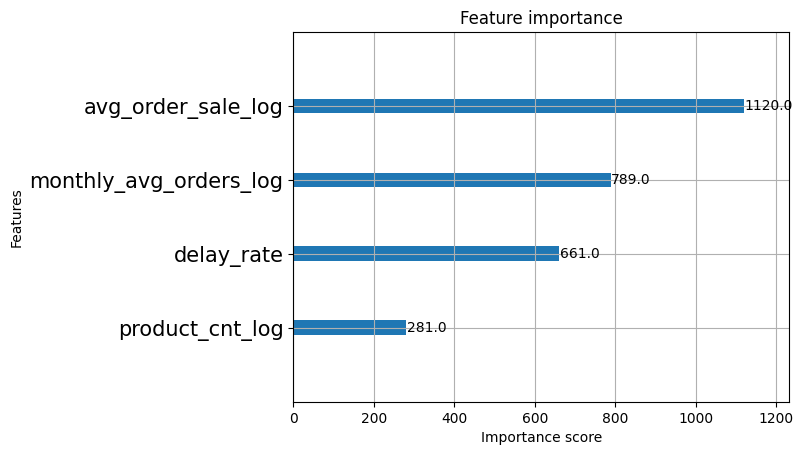

In [ ]:
from xgboost import plot_importance
plot_importance(best_model_review_score)
plt.yticks(fontsize=15)
plt.show()

rf 모델 실험 2

In [ ]:
train['review_score_x_product_cnt'] = train['review_score'] * train['product_cnt']
test['review_score_x_product_cnt'] = test['review_score'] * test['product_cnt']

In [ ]:
features = ['review_score', 'delay_rate', 'product_cnt_log', 'review_score_x_product_cnt']  # 사용하고자 하는 feature명
target = 'total_sale' # 예측 대상 컬럼명
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 0.7, None]
}

grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search_rf.fit(X_train, y_train)
print("Best Params:", grid_search_rf.best_params_)
print("Best score(Negative RMSE):", grid_search_rf.best_score_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 500}
Best score(Negative RMSE): -2428.730055327306


In [ ]:
# 예측 및 평가
y_pred_rf = grid_search_rf.predict(X_test)
regression_metrics(y_test, y_pred_rf, n_features=X_test.shape[1])

{'MSE': 66290044.75815683,
 'MAE': 2718.4342059677356,
 'RMSE': np.float64(8141.869856375551),
 'R2': 0.39400814722755795,
 'Adjusted R2': 0.3925540575988299}

/tmp/ipython-input-2777981153.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')


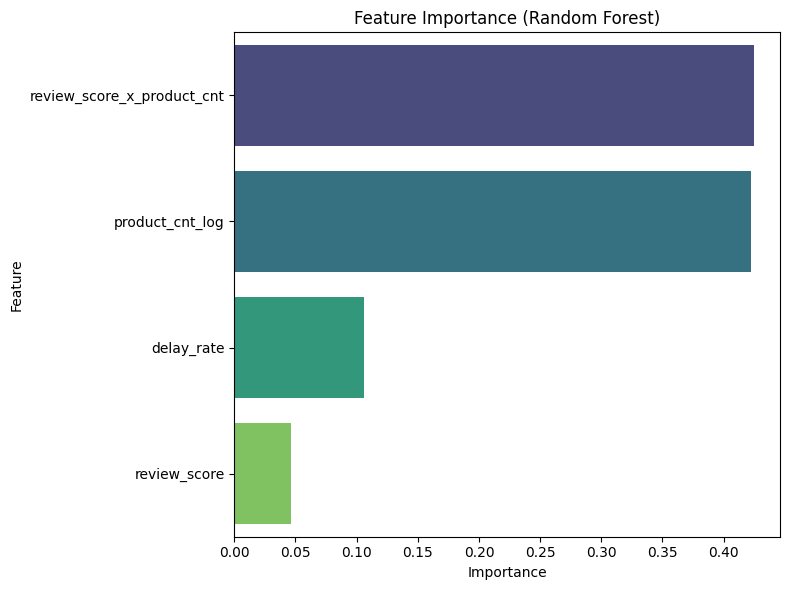

In [ ]:
# 모델과 feature 이름을 준비
model = grid_search_rf.best_estimator_
importances = model.feature_importances_
feature_names = X_train.columns  # X_train이 DataFrame이면 .columns 가능

# 데이터프레임으로 정리
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()
